In [1]:
# sudo apt install -y fluidsynth
# pip install --upgrade pyfluidsynth
# pip install pretty_midi

In [2]:
import collections
import datetime
import glob
import numpy as np
import pathlib
import pandas as pd
import pretty_midi
import seaborn as sns
import tensorflow as tf
from IPython import display
from matplotlib import pyplot as plt
from typing import Dict, List, Optional, Sequence, Tuple
from tensorflow.keras.optimizers import RMSprop


2024-04-10 16:27:23.590639: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-10 16:27:23.700007: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-10 16:27:23.700047: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-10 16:27:23.708773: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-10 16:27:23.733923: I tensorflow/core/platform/cpu_feature_guar

In [3]:
import fluidsynth

In [4]:
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

# Sampling rate for audio playback
_SAMPLING_RATE = 16000

In [5]:
filenames = glob.glob(str("MIDI/pop/**/*.mid"))
# filenames = glob.glob(str("/home/jayden/projects/project_lyrics/MIDI/pop/**/*.mid"))
print('Number of files: ', len(filenames))
sample_file = filenames[1]
print(sample_file)

Number of files:  2898
MIDI/pop/Marcels/IWantYouToLoveMe.mid


In [6]:
pm = pretty_midi.PrettyMIDI(sample_file)

In [7]:
#오디오를 30초간 들을수 있게 시험.
def display_audio(pm: pretty_midi.PrettyMIDI, seconds=30):
  waveform = pm.fluidsynth(fs=_SAMPLING_RATE)
  # Take a sample of the generated waveform to mitigate kernel resets
  waveform_short = waveform[:seconds*_SAMPLING_RATE]
  return display.Audio(waveform_short, rate=_SAMPLING_RATE)

In [8]:
display_audio(pm)

In [9]:
#악기 종류 찾아내기
print('Number of instruments:', len(pm.instruments))
instrument = pm.instruments[0]
instrument_name = pretty_midi.program_to_instrument_name(instrument.program)
print('Instrument name:', instrument_name)

for num in range(len(pm.instruments)):
    print('All instruments:' , pretty_midi.program_to_instrument_name(pm.instruments[num].program))

Number of instruments: 12
Instrument name: Acoustic Grand Piano
All instruments: Acoustic Grand Piano
All instruments: Electric Grand Piano
All instruments: Acoustic Guitar (steel)
All instruments: Acoustic Guitar (steel)
All instruments: Shakuhachi
All instruments: Rock Organ
All instruments: Electric Bass (finger)
All instruments: Electric Guitar (jazz)
All instruments: Choir Aahs
All instruments: String Ensemble 1
All instruments: Acoustic Grand Piano
All instruments: Electric Guitar (clean)


In [10]:
#하나의 악기에서 음악 노트 추출
for i, note in enumerate(instrument.notes[:10]):
  note_name = pretty_midi.note_number_to_name(note.pitch)
  duration = note.end - note.start
  print(f'{i}: pitch={note.pitch}, note_name={note_name},'
        f' duration={duration:.4f}')

print(len(instrument.notes))

0: pitch=42, note_name=F#2, duration=0.0130
1: pitch=42, note_name=F#2, duration=0.0130
2: pitch=42, note_name=F#2, duration=0.0130
3: pitch=42, note_name=F#2, duration=0.0130
4: pitch=44, note_name=G#2, duration=0.0130
5: pitch=44, note_name=G#2, duration=0.0130
6: pitch=44, note_name=G#2, duration=0.0130
7: pitch=44, note_name=G#2, duration=0.0130
8: pitch=44, note_name=G#2, duration=0.0130
9: pitch=44, note_name=G#2, duration=0.0130
1025


In [11]:
# training model requires 3 variables (pitch, step, duration)
# pitch : perceptual quality of the sound as a midi note
# step : time elapsed from previous note or start of the track
# duration : duration of the current note
# 미디 파일에서 음표 추출하는 부분.

# return pd.DataFrame
def midi_to_notes(midi_file: str):
  try:
    pm = pretty_midi.PrettyMIDI(midi_file)
    instrument = pm.instruments[0] #val of single instrument
    notes = collections.defaultdict(list)

    # Sort the notes by start time
    sorted_notes = sorted(instrument.notes, key=lambda note: note.start)
    prev_start = sorted_notes[0].start

    for note in sorted_notes:
      start = note.start
      end = note.end
      notes['pitch'].append(note.pitch)
      notes['start'].append(start)
      notes['end'].append(end)
      notes['step'].append(start - prev_start)
      notes['duration'].append(end - start)
      prev_start = start
    return pd.DataFrame({name: np.array(value) for name, value in notes.items()})
  except OSError as e:
    print(f"Error processing MIDI file '{midi_file}': {e}")
  except ValueError as ve:
    print(f"ValueError occurred while processing file {midi_file}: {ve}")
  except Exception as e:
    print(f"Error occurred while processing file {midi_file}: {e}")

  

In [12]:
raw_notes = midi_to_notes(sample_file)
raw_notes.head(20)

,pitch,start,end,step,duration
0,42,1.123377,1.136364,0.000000,0.012987
1,42,1.902598,1.915585,0.779221,0.012987
2,42,2.681819,2.694806,0.779221,0.012987
3,42,3.461040,3.474027,0.779221,0.012987
4,44,5.019482,5.032469,1.558442,0.012987
5,44,6.577924,6.590911,1.558442,0.012987
6,44,8.136366,8.149353,1.558442,0.012987
7,44,9.694808,9.707795,1.558442,0.012987
8,44,11.253250,11.266237,1.558442,0.012987
9,44,12.811692,12.824679,1.558442,0.012987


## Visualization

In [13]:
#음표로 바꿔서 해석해보기.
get_note_names = np.vectorize(pretty_midi.note_number_to_name)
sample_note_names = get_note_names(raw_notes['pitch'])
sample_note_names[:10]

array(['F#2', 'F#2', 'F#2', 'F#2', 'G#2', 'G#2', 'G#2', 'G#2', 'G#2',
       'G#2'], dtype='<U3')

In [14]:
# 악곡은 노트의 연속성이니 시각화 해보기. 첫번쨰 instrument 가 피아노니까 트랙 길이에 음표, 피치, 시작 & 끝을 플롯해보기.
# count 는 input 에 있거나 없거나 상관없음. 
def plot_piano_roll(notes: pd.DataFrame, count: Optional[int] = None):
  if count:
    title = f'First {count} notes'
  else:
    title = f'Whole track'
    count = len(notes['pitch'])
  plt.figure(figsize=(20, 4))
  plot_pitch = np.stack([notes['pitch'], notes['pitch']], axis=0)
  plot_start_stop = np.stack([notes['start'], notes['end']], axis=0)
  plt.plot(
      plot_start_stop[:, :count], plot_pitch[:, :count], color="b", marker=".")
  plt.xlabel('Time [s]')
  plt.ylabel('Pitch')
  _ = plt.title(title)

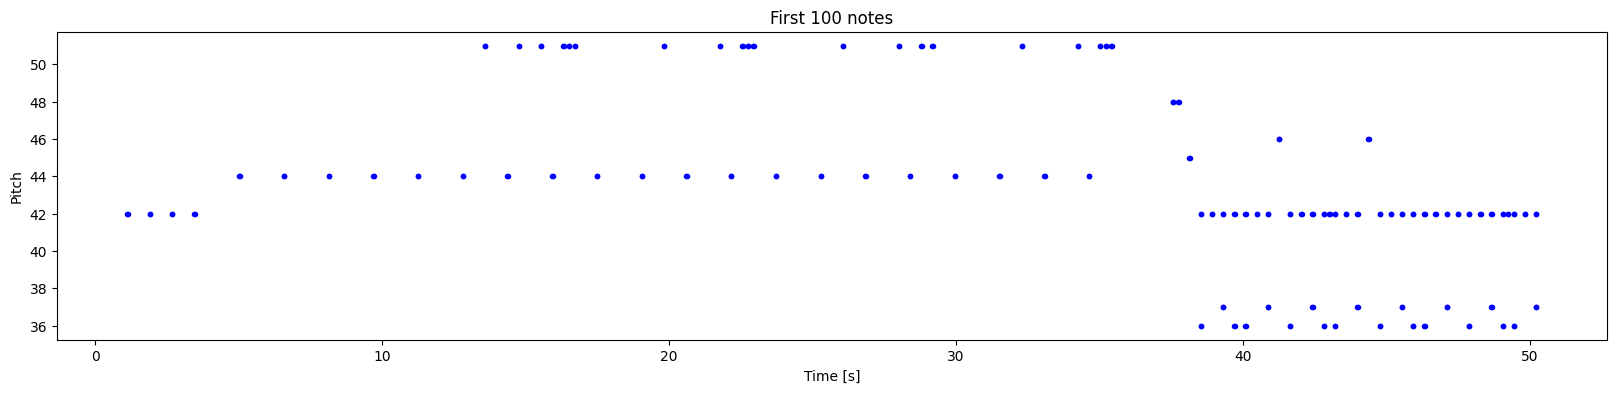

In [15]:
plot_piano_roll(raw_notes, count=100)

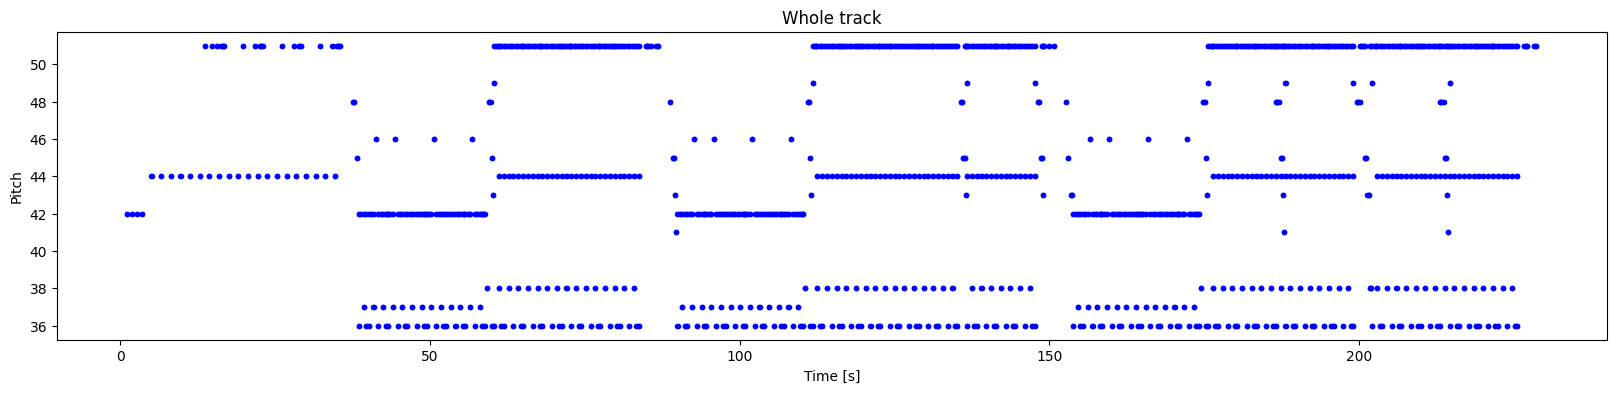

In [16]:
# 전체 트랙의 음악 노트 표현.
plot_piano_roll(raw_notes)

In [17]:
def plot_distributions(notes: pd.DataFrame, drop_percentile=2.5):
  plt.figure(figsize=[15, 5])
  plt.subplot(1, 3, 1)
  sns.histplot(notes, x="pitch", bins=20)

  plt.subplot(1, 3, 2)
  max_step = np.percentile(notes['step'], 100 - drop_percentile)
  sns.histplot(notes, x="step", bins=np.linspace(0, max_step, 21))

  plt.subplot(1, 3, 3)
  max_duration = np.percentile(notes['duration'], 100 - drop_percentile)
  sns.histplot(notes, x="duration", bins=np.linspace(0, max_duration, 21))

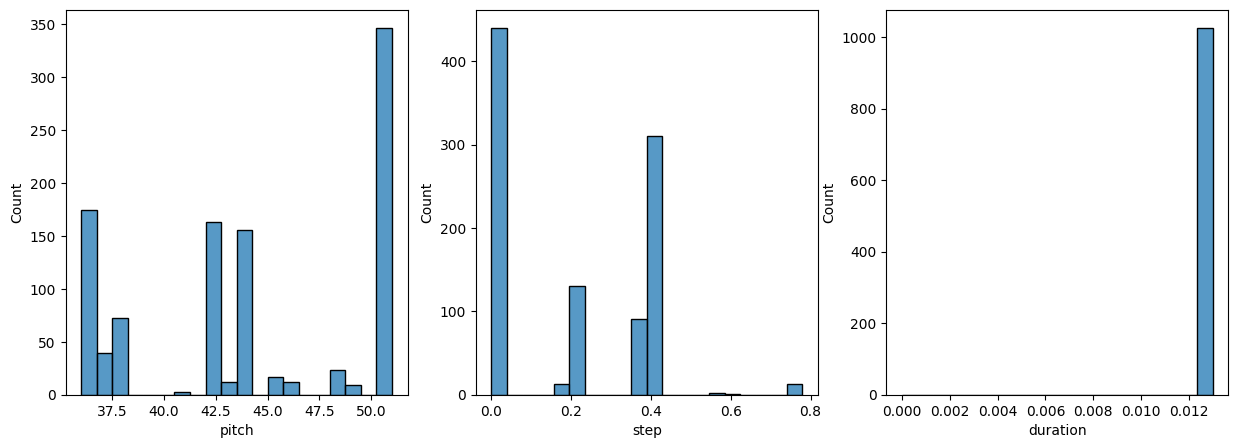

In [18]:
plot_distributions(raw_notes)

## MIDI 파일 생성

In [19]:
def notes_to_midi(
  notes: pd.DataFrame,
  out_file: str, 
  instrument_name: str,
  velocity: int = 100,  # note loudness
) -> pretty_midi.PrettyMIDI:

  pm = pretty_midi.PrettyMIDI()
  instrument = pretty_midi.Instrument(
      program=pretty_midi.instrument_name_to_program(
          instrument_name)) #피아노를 넣으면 피아노가 있는 경우에 그것의 맞는 Pretty midi instrument 숫자를 리턴

  prev_start = 0
  for i, note in notes.iterrows():
    start = float(prev_start + note['step'])
    end = float(start + note['duration'])
    note = pretty_midi.Note(
        velocity=velocity,
        pitch=int(note['pitch']),
        start=start,
        end=end,
    )
    instrument.notes.append(note)
    prev_start = start

  pm.instruments.append(instrument)
  pm.write(out_file)
  return pm

In [20]:
example_file = 'example.midi'
example_pm = notes_to_midi(
    raw_notes, out_file=example_file, instrument_name=instrument_name)

In [21]:
display_audio(example_pm)

## 훈련 데이터 세트 생성

In [22]:
# MIDI 파일에서 노트 추출하기. 적은수로 실험
num_files = 200 #일단 작은 숫자로 트레이닝.
all_notes = []
for f in filenames[:num_files]:
  notes = midi_to_notes(f)
  all_notes.append(notes)

all_notes = pd.concat(all_notes)

/home/jayden/miniconda3/envs/aimusic/lib/python3.11/site-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(


In [23]:
n_notes = len(all_notes)
print('Number of notes parsed:', n_notes)

Number of notes parsed: 193714


In [24]:
all_notes.head()

,pitch,start,end,step,duration
0,70,17.922083,18.214291,0.00000,0.292208
1,70,18.311693,18.584421,0.38961,0.272727
2,70,18.701304,18.961044,0.38961,0.259740
3,70,19.090914,19.331174,0.38961,0.240260
4,72,19.480525,19.707798,0.38961,0.227273


In [25]:
#create tensor dataset
key_order = ['pitch', 'step', 'duration']
train_notes = np.stack([all_notes[key] for key in key_order], axis=1)

In [26]:
train_notes

array([[70.        ,  0.        ,  0.29220787],
       [70.        ,  0.3896105 ,  0.27272735],
       [70.        ,  0.3896105 ,  0.25974033],
       ...,
       [46.        ,  0.87083333,  0.22083333],
       [51.        ,  0.12916667,  0.7625    ],
       [39.        ,  0.87083333,  1.12916667]])

In [27]:
notes_ds = tf.data.Dataset.from_tensor_slices(train_notes)
notes_ds.element_spec

2024-04-10 16:27:38.485083: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:274] failed call to cuInit: UNKNOWN ERROR (100)


TensorSpec(shape=(3,), dtype=tf.float64, name=None)

In [28]:
#노트 시퀀스로 다음 음표 예측 훈련.
#기존에 있는 노트들을 시퀀스로 묶고 그것으로 다음 시퀀스 예측.
#시퀀스가 길수록 한번에 묶여있는 노트의 숫자 증가.

def create_sequences(
    dataset: tf.data.Dataset, 
    seq_length: int,
    vocab_size = 128,
) -> tf.data.Dataset:
  """Returns TF Dataset of sequence and label examples."""
  seq_length = seq_length+1

  # Take 1 extra for the labels
  windows = dataset.window(seq_length, shift=1, stride=1,
                              drop_remainder=True)

  # `flat_map` flattens the" dataset of datasets" into a dataset of tensors
  flatten = lambda x: x.batch(seq_length, drop_remainder=True)
  sequences = windows.flat_map(flatten)

  # Normalize note pitch
  def scale_pitch(x):
    x = x/[vocab_size,1.0,1.0]
    return x

  # Split the labels
  def split_labels(sequences):
    inputs = sequences[:-1]
    labels_dense = sequences[-1]
    labels = {key:labels_dense[i] for i,key in enumerate(key_order)}

    return scale_pitch(inputs), labels

  return sequences.map(split_labels, num_parallel_calls=tf.data.AUTOTUNE)

In [29]:
#시퀀스 길이 조정. 
seq_length = 25 #변환 가능.
vocab_size = 128 #pretty_midi 의 최대 피치 수.
seq_ds = create_sequences(notes_ds, seq_length, vocab_size)
seq_ds.element_spec

(TensorSpec(shape=(25, 3), dtype=tf.float64, name=None),
 {'pitch': TensorSpec(shape=(), dtype=tf.float64, name=None),
  'step': TensorSpec(shape=(), dtype=tf.float64, name=None),
  'duration': TensorSpec(shape=(), dtype=tf.float64, name=None)})

In [30]:
for seq, target in seq_ds.take(1):
  print('sequence shape:', seq.shape)
  print('sequence elements (first 10):', seq[0: 10])
  print()
  print('target:', target)

sequence shape: (25, 3)
sequence elements (first 10): tf.Tensor(
[[0.546875   0.         0.29220787]
 [0.546875   0.3896105  0.27272735]
 [0.546875   0.3896105  0.25974033]
 [0.546875   0.3896105  0.24025981]
 [0.5625     0.3896105  0.22727279]
 [0.578125   0.3896105  0.14285718]
 [0.5078125  0.19480525 3.66883221]
 [0.5078125  4.675326   0.0779221 ]
 [0.546875   0.19480525 0.27272735]
 [0.546875   0.3896105  0.24025981]], shape=(10, 3), dtype=float64)

target: {'pitch': <tf.Tensor: shape=(), dtype=float64, numpy=70.0>, 'step': <tf.Tensor: shape=(), dtype=float64, numpy=0.3896104999999963>, 'duration': <tf.Tensor: shape=(), dtype=float64, numpy=0.305194891666666>}


In [31]:
batch_size = 64
buffer_size = n_notes - seq_length  # the number of items in the dataset
train_ds = (seq_ds
            .shuffle(buffer_size)
            .batch(batch_size, drop_remainder=True)
            .cache()
            .prefetch(tf.data.experimental.AUTOTUNE))

In [32]:
train_ds.element_spec

(TensorSpec(shape=(64, 25, 3), dtype=tf.float64, name=None),
 {'pitch': TensorSpec(shape=(64,), dtype=tf.float64, name=None),
  'step': TensorSpec(shape=(64,), dtype=tf.float64, name=None),
  'duration': TensorSpec(shape=(64,), dtype=tf.float64, name=None)})

모델 생성 및 학습

In [33]:
# 음수 말고 양수쪽으로 움직이게 weight 를 더 주기.

def mse_with_positive_pressure(y_true: tf.Tensor, y_pred: tf.Tensor):
  mse = (y_true - y_pred) ** 2
  positive_pressure = 10 * tf.maximum(-y_pred, 0.0)
  return tf.reduce_mean(mse + positive_pressure)

In [34]:
input_shape = (seq_length, 3)
learning_rate = 0.005

inputs = tf.keras.Input(input_shape)
x = tf.keras.layers.LSTM(128)(inputs)

outputs = {
  'pitch': tf.keras.layers.Dense(128, name='pitch')(x),
  'step': tf.keras.layers.Dense(1, name='step')(x),
  'duration': tf.keras.layers.Dense(1, name='duration')(x),
}

model = tf.keras.Model(inputs, outputs)

loss = {
      'pitch': tf.keras.losses.SparseCategoricalCrossentropy(
          from_logits=True),
      'step': mse_with_positive_pressure,
      'duration': mse_with_positive_pressure,
}

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

model.compile(loss=loss, optimizer=optimizer)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 25, 3)]              0         []                            
                                                                                                  
 lstm (LSTM)                 (None, 128)                  67584     ['input_1[0][0]']             
                                                                                                  
 duration (Dense)            (None, 1)                    129       ['lstm[0][0]']                
                                                                                                  
 pitch (Dense)               (None, 128)                  16512     ['lstm[0][0]']                
                                                                                              

In [35]:
losses = model.evaluate(train_ds, return_dict=True)
losses

2024-04-10 16:27:49.263080: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:38: Filling up shuffle buffer (this may take a while): 132880 of 193689


     20/Unknown - 15s 5ms/step - loss: 5.8637 - duration_loss: 0.7874 - pitch_loss: 4.8554 - step_loss: 0.2209

2024-04-10 16:27:53.763557: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


3026/3026 [==============================] - 28s 4ms/step - loss: 6.1091 - duration_loss: 0.7199 - pitch_loss: 4.8559 - step_loss: 0.5332


{'loss': 6.1090922355651855,
 'duration_loss': 0.7199328541755676,
 'pitch_loss': 4.855917453765869,
 'step_loss': 0.5332497954368591}

In [36]:
model.compile(
    loss=loss,
    loss_weights={
        'pitch': 0.05,
        'step': 1.0,
        'duration':1.0,
    },
    optimizer=optimizer,
)

In [37]:
model.evaluate(train_ds, return_dict=True)

3026/3026 [==============================] - 15s 5ms/step - loss: 1.4960 - duration_loss: 0.7199 - pitch_loss: 4.8559 - step_loss: 0.5332


{'loss': 1.4959772825241089,
 'duration_loss': 0.7199328541755676,
 'pitch_loss': 4.855917453765869,
 'step_loss': 0.5332497954368591}

In [38]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='loss',
        patience=5,
        verbose=1,
        restore_best_weights=True),
]

In [39]:
%%time
epochs = 50

history = model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
)

Epoch 1/50
3026/3026 [==============================] - 30s 10ms/step - loss: 0.6343 - duration_loss: 0.0885 - pitch_loss: 3.3388 - step_loss: 0.3789
Epoch 2/50
3026/3026 [==============================] - 29s 9ms/step - loss: 0.5910 - duration_loss: 0.0822 - pitch_loss: 2.9933 - step_loss: 0.3591
Epoch 3/50
3026/3026 [==============================] - 28s 9ms/step - loss: 0.5728 - duration_loss: 0.0791 - pitch_loss: 2.8362 - step_loss: 0.3518
Epoch 4/50
3026/3026 [==============================] - 29s 9ms/step - loss: 0.5589 - duration_loss: 0.0769 - pitch_loss: 2.7077 - step_loss: 0.3466
Epoch 5/50
3026/3026 [==============================] - 28s 9ms/step - loss: 0.5535 - duration_loss: 0.0768 - pitch_loss: 2.6688 - step_loss: 0.3433
Epoch 6/50
3026/3026 [==============================] - 28s 9ms/step - loss: 0.5494 - duration_loss: 0.0758 - pitch_loss: 2.6219 - step_loss: 0.3426
Epoch 7/50
3026/3026 [==============================] - 28s 9ms/step - loss: 0.5386 - duration_loss: 0.07

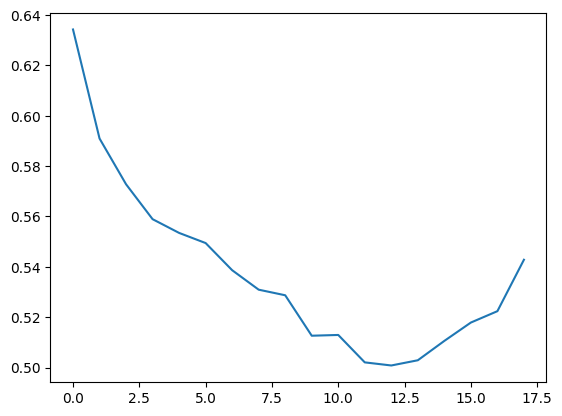

In [40]:
plt.plot(history.epoch, history.history['loss'], label='total loss')
plt.show()

Generating the notes

In [41]:
# 예측을 하려면 노트의 시퀀스를 넣어야함.
# 노트의 시퀀스를 만들어서 넣기.
# 노트 피치는 소프트맥스 함수로 나눠진거에서 샘플로 여러개를 가지고 오고 제일 높은 확률만 가져오지 않음

def predict_next_note(
    notes: np.ndarray, 
    keras_model: tf.keras.Model, 
    temperature: float = 1.0) -> int:
  """Generates a note IDs using a trained sequence model."""

  assert temperature > 0 #온도가 노트들 랜덤생성하게 하는거 도와주는 펑션

  # Add batch dimension
  inputs = tf.expand_dims(notes, 0)

  predictions = model.predict(inputs)
  pitch_logits = predictions['pitch']
  step = predictions['step']
  duration = predictions['duration']

  pitch_logits /= temperature
  pitch = tf.random.categorical(pitch_logits, num_samples=1)
  pitch = tf.squeeze(pitch, axis=-1)
  duration = tf.squeeze(duration, axis=-1)
  step = tf.squeeze(step, axis=-1)

  # `step` and `duration` values should be non-negative
  step = tf.maximum(0, step)
  duration = tf.maximum(0, duration)

  return int(pitch), float(step), float(duration)

실제로 만들어보기

In [42]:
raw_notes = midi_to_notes(filenames[1])

In [43]:
#온도, 시작 시퀀스 가지고 바꿔보기.
temperature = 2.0
num_predictions = 120

sample_notes = np.stack([raw_notes[key] for key in key_order], axis=1)

# The initial sequence of notes; pitch is normalized similar to training sequences
input_notes = (
    sample_notes[:seq_length] / np.array([vocab_size, 1, 1]))

generated_notes = []
prev_start = 0
for _ in range(num_predictions):
  pitch, step, duration = predict_next_note(input_notes, model, temperature)
  start = prev_start + step
  end = start + duration
  input_note = (pitch, step, duration)
  generated_notes.append((*input_note, start, end))
  input_notes = np.delete(input_notes, 0, axis=0)
  input_notes = np.append(input_notes, np.expand_dims(input_note, 0), axis=0)
  prev_start = start

generated_notes = pd.DataFrame(
    generated_notes, columns=(*key_order, 'start', 'end'))

1/1 [==============================] - 0s 11ms/step


In [44]:
generated_notes.head(10)

,pitch,step,duration,start,end
0,43,0.567254,0.089886,0.567254,0.657140
1,88,0.000000,0.000000,0.567254,0.567254
2,88,0.000000,0.000000,0.567254,0.567254
3,83,0.000000,0.000000,0.567254,0.567254
4,83,0.000000,0.000000,0.567254,0.567254
5,83,0.000000,0.000000,0.567254,0.567254
6,78,0.000000,0.000000,0.567254,0.567254
7,83,0.044039,0.000000,0.611293,0.611293
8,74,0.096508,0.000000,0.707801,0.707801
9,83,0.181406,0.000000,0.889208,0.889208


In [45]:
out_file = 'sample/output4.mid'
out_pm = notes_to_midi(
    generated_notes, out_file=out_file, instrument_name=instrument_name)
display_audio(out_pm)

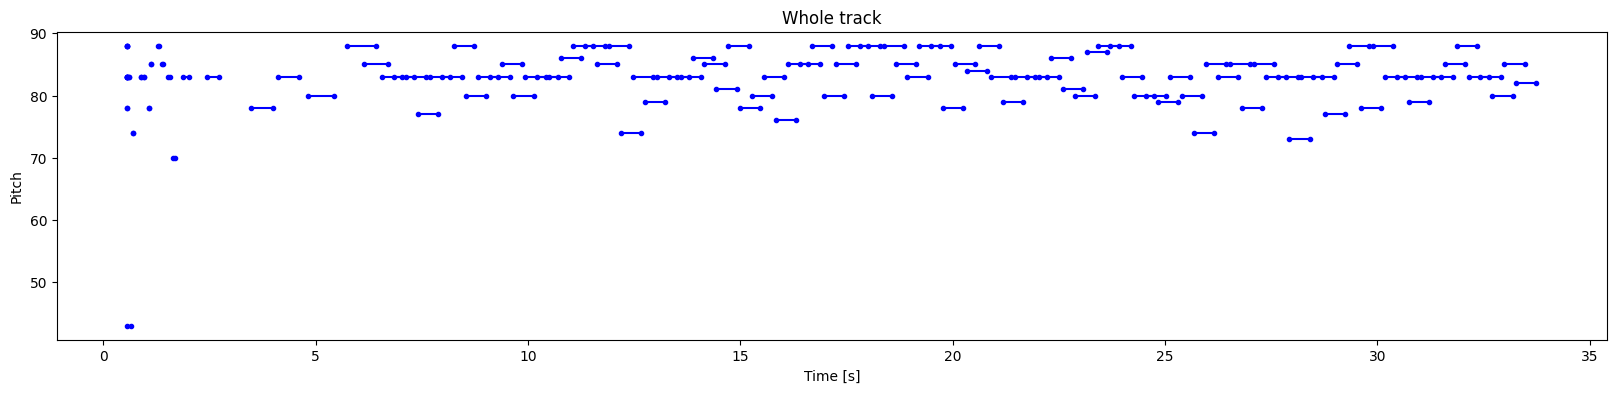

In [46]:
plot_piano_roll(generated_notes)

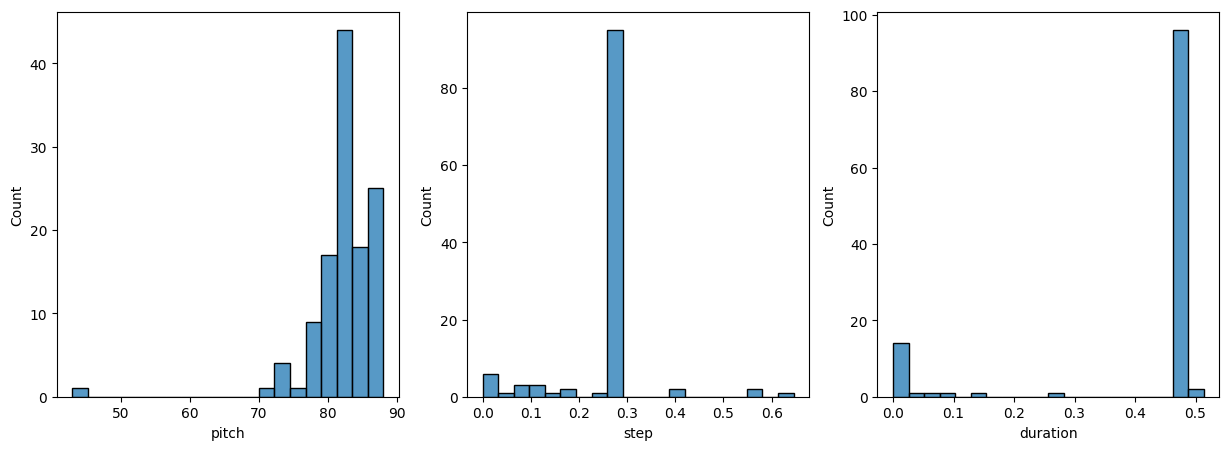

In [47]:
plot_distributions(generated_notes)